In [3]:
import numpy as np

In [7]:
f = open("image.jpg", 'rb')
print(type(f))
data = np.frombuffer(f.read(), np.uint8, offset=16)
print(data)
print(type(data))
print(data.shape)
f.close()

<class '_io.BufferedReader'>
[  0   1   0 ...,  15 255 217]
<class 'numpy.ndarray'>
(38044,)


In [9]:
np.ndarray.tofile("image.jpg")

TypeError: descriptor 'tofile' requires a 'numpy.ndarray' object but received a 'str'

In [11]:
import numpy as np
from PIL import Image
foo = Image.open("image.jpg")
foo = foo.resize((299, 299), Image.ANTIALIAS)
np.array(foo.convert("L")) # numpy array 완성

array([[147, 146, 145, ...,  94,  95,  94],
       [148, 147, 146, ...,  93,  95,  95],
       [150, 148, 148, ...,  94,  95,  94],
       ..., 
       [104, 105, 106, ...,  84,  84,  85],
       [104, 105, 107, ...,  83,  83,  83],
       [108, 107, 108, ...,  84,  84,  84]], dtype=uint8)

In [25]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt # 변환된 이미지를 확인하기 위해 import 합니다
import random
FLAGS = tf.app.flags.FLAGS # 프로젝트 전역으로 변수를 공유합니다
FLAGS.width = 256
FLAGS.height = 256
FLAGS.depth = 3
batch_index = 0
FLAGS.num_class = 3
FLAGS.data_dir = './RP_data_2'
filenames = []
def get_filenames(data_set): # 하위 디렉토리를 돌면서 파일 이름을 가져옵니다
    global filenames
    labels = []
    with open(FLAGS.data_dir + '/labels.txt') as f:
        for line in f: # 파일에서 라인 읽어오는 부분
            inner_list = [elt.strip() for elt in line.split(',')]
            labels += inner_list # label을 리스트에 넣어줍니다

    for i, label in enumerate(labels): # label 디렉토리 안에 파일들을 검색해서 리스트에 넣어줍니다
        list = os.listdir(FLAGS.data_dir  + '/' + data_set + '/' + label)
        for filename in list:
            # 파일 이름과 label에 해당하는 번호를 묶어서 리스트에 추가합니다
            filenames.append([label + '/' + filename, i]) 

    random.shuffle(filenames) # 파일이름, label 쌍으로 되어있는 리스트를 섞어줍니다

def get_data_jpeg(sess, data_set, batch_size):
    global batch_index, filenames

    if len(filenames) == 0: get_filenames(data_set) # 파일 이름들을 읽어오지 않았다면 읽어옵니다
    max = len(filenames)
    # 현재 index 부터 batch_size 만큼 읽어오기 위해 범위를 정해줍니다
    begin = batch_index
    end = batch_index + batch_size

    if end >= max: # 범위가 넘어가면 index를 다시 0으로 설정합니다
        end = max
        batch_index = 0

    x_data = np.array([])
    y_data = np.zeros((batch_size, FLAGS.num_class)) # one hot encoding을 위해 0으로 채워진 리스트를 만듭니다
    index = 0

    for i in range(begin, end):
        # 파일을 얽어옵니다
        with tf.gfile.FastGFile(FLAGS.data_dir + '/' + data_set + '/' + filenames[i][0], 'rb') as f:
            image_data = f.read()
        # JPEG 이미지이므로 decoding을 해야 합니다
        decode_image = tf.image.decode_jpeg(image_data, channels=FLAGS.depth)
        # model에 맞추기 위해 resize 합니다. method=1 일때만 동작합니다. 
        # 다른건 왜 안되는지 잘 모르겠습니다. 아시는 분은 답글 부탁드립니다 
        resized_image = tf.image.resize_images(decode_image, FLAGS.height, FLAGS.width, method=1) 
        image = sess.run(resized_image) # 위에서 만든 operation을 실행합니다
        # string 형식의 데이터를 Tensorflow에 입력하기 위해 array로 바꿔줍니다. 
        # 반드시 float 타입이어야 하며 255로 나누어서 nomalize 해줘야 합니다. 
        # 안나누고 그냥 하면 cross entropy가 계속 nan으로 나옵니다
        x_data = np.append(x_data, np.asarray(image.data, dtype='float32')) / 255 
        y_data[index][filenames[i][1]] = 1 # label에 해당하는 column을 1로 설정합니다 (one hot encoding)
        index += 1

        # 변환된 이미지를 확인하려면 아래 주석을 해제하세요
        # print image.shape, len(image.data)
        # im = np.reshape(image.data, (256, 256, 3))
        # plt.imshow(im)
        # plt.show()

    batch_index += batch_size # 다음 batch를 위해 index를 갱신합니다
    try:
        # 깨진 JPEG 이미지는 여기서 exception이 발생합니다
        # Tensorflow에 넣기 위해 2D로 shape을 변경합니다
        x_data = x_data.reshape(batch_size, FLAGS.height * FLAGS.width * FLAGS.depth)
    except:
        return None, None

    return x_data, y_data



In [26]:
with tf.Session() as sess:
    get_data_jpeg(sess, 'train', 1)

ValueError: 'size' must be a 1-D Tensor of 2 elements: new_height, new_width

In [27]:
red = tf.constant([255,0,0])

In [28]:
image_filename="./test-input-image-large.jpg"

In [29]:
filename_queue = tf.train.string_input_producer(tf.train.match_filenames_once(image_filename))

In [30]:
filename_queue

In [36]:
print(type(filename_queue))

<class 'tensorflow.python.ops.data_flow_ops.FIFOQueue'>


In [37]:
image_reader = tf.WholeFileReader()

In [39]:
_, image_file = image_reader.read(filename_queue)

In [42]:
print(type(image_file))
image = tf.image.decode_jpeg(image_file)

<class 'tensorflow.python.framework.ops.Tensor'>


In [43]:
image

<tf.Tensor 'DecodeJpeg_4:0' shape=(?, ?, ?) dtype=uint8>

In [44]:
print(type(image))

<class 'tensorflow.python.framework.ops.Tensor'>


In [45]:
print(image.dtype)

<dtype: 'uint8'>


In [46]:
print(image.get_shape)

<bound method Tensor.get_shape of <tf.Tensor 'DecodeJpeg_4:0' shape=(?, ?, ?) dtype=uint8>>


In [47]:
print(image.shape)

(?, ?, ?)


In [ ]:
with tf.Session() as sess:
    sess.run(image)

In [1]:
import glob
image_filenames = glob.glob("./RP_data_3/critical/*.png")

In [2]:
image_filenames = glob.glob("./RP_data_3/critical/*.png")

In [4]:
image_filenames[0:10]

['./RP_data_3/critical/NeuroSafe-20170712_120329_321515.png',
 './RP_data_3/critical/NeuroSafe-20170712_121145_045390.png',
 './RP_data_3/critical/NeuroSafe-20170712_121250_575724.png',
 './RP_data_3/critical/NeuroSafe-20170712_121252_706899.png',
 './RP_data_3/critical/NeuroSafe-20170712_130540_211816.png',
 './RP_data_3/critical/NeuroSafe-20170712_183940_048625.png',
 './RP_data_3/critical/NeuroSafe-20170712_184600_661452.png',
 './RP_data_3/critical/NeuroSafe-20170712_190510_514202.png',
 './RP_data_3/critical/NeuroSafe-20170712_190526_080476.png',
 './RP_data_3/critical/NeuroSafe-20170712_190528_037250.png']

In [5]:
from itertools import groupby

In [6]:
from collections import defaultdict

In [95]:
_training_dataset = defaultdict(list)

In [96]:
_testing_dataset = defaultdict(list)

In [97]:
image_filename_with_breed = map(lambda filename: (filename.split("/")[2], filename), image_filenames)

In [99]:
for category, _images in groupby(image_filename_with_breed, lambda x: x[0]):
    for i, _images in enumerate(_images):
        if i%5 == 0:
            _testing_dataset[category].append(_images[1])
        else :
            _training_dataset[category].append(_images[1])
    _training_count = len(_training_dataset[category])
    _testing_count = len(_testing_dataset[category])
    
    assert round(_testing_count / (_training_count + _testing_count), 2) > 0.2, "Not enough testing images."

In [100]:
import tensorflow as tf

In [101]:
def write_records_file(dataset, record_location):
    """
    Fill a TFRecords file with the images found in `dataset` and include their category.

    Parameters
    ----------
    dataset : dict(list)
      Dictionary with each key being a label for the list of image filenames of its value.
    record_location : str
      Location to store the TFRecord output.
    """
    writer = None

    # Enumerating the dataset because the current index is used to breakup the files if they get over 100
    # images to avoid a slowdown in writing.
    current_index = 0
    for category, images_filenames in dataset.items():
        for image_filename in images_filenames:
            if current_index % 100 == 0:
                if writer:
                    writer.close()

                record_filename = "{record_location}-{current_index}.tfrecords".format(
                    record_location=record_location,
                    current_index=current_index)

                writer = tf.python_io.TFRecordWriter(record_filename)
            current_index += 1

            image_file = tf.read_file(image_filename)

            # In ImageNet dogs, there are a few images which TensorFlow doesn't recognize as JPEGs. This
            # try/catch will ignore those images.
            try:
                image = tf.image.decode_png(image_file)
            except:
                print(image_filename)
                continue

            # Converting to grayscale saves processing and memory but isn't required.
            grayscale_image = tf.image.rgb_to_grayscale(image)
            resized_image = tf.image.resize_images(grayscale_image, (299, 299))

            # tf.cast is used here because the resized images are floats but haven't been converted into
            # image floats where an RGB value is between [0,1).
            image_bytes = tf.Session.run(tf.cast(resized_image, tf.uint8)).tobytes()

            # Instead of using the label as a string, it'd be more efficient to turn it into either an
            # integer index or a one-hot encoded rank one tensor.
            # https://en.wikipedia.org/wiki/One-hot
            image_label = category.encode("utf-8")

            example = tf.train.Example(features=tf.train.Features(feature={
                'label': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_label])),
                'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_bytes]))
            }))

            writer.write(example.SerializeToString())
    writer.close()

write_records_file(testing_dataset, "./output/training_images/")
write_records_file(training_dataset, "./output/testing_images/")

TypeError: run() missing 1 required positional argument: 'fetches'

In [36]:
import imageflow

In [ ]:
B

In [37]:
import glob
import imageflow
import tensorflow as tf

In [38]:
image_filenames = glob.glob("./RP_data_3/critical/*.png")

In [39]:
image_filenames[:]

['./RP_data_3/critical/NeuroSafe-20170712_120329_321515.png',
 './RP_data_3/critical/NeuroSafe-20170712_121145_045390.png',
 './RP_data_3/critical/NeuroSafe-20170712_121250_575724.png',
 './RP_data_3/critical/NeuroSafe-20170712_121252_706899.png',
 './RP_data_3/critical/NeuroSafe-20170712_130540_211816.png',
 './RP_data_3/critical/NeuroSafe-20170712_183940_048625.png',
 './RP_data_3/critical/NeuroSafe-20170712_184600_661452.png',
 './RP_data_3/critical/NeuroSafe-20170712_190510_514202.png',
 './RP_data_3/critical/NeuroSafe-20170712_190526_080476.png',
 './RP_data_3/critical/NeuroSafe-20170712_190528_037250.png',
 './RP_data_3/critical/NeuroSafe-20170712_190538_506576.png',
 './RP_data_3/critical/NeuroSafe-20170712_190540_350788.png',
 './RP_data_3/critical/NeuroSafe-20170712_190547_755733.png',
 './RP_data_3/critical/NeuroSafe-20170712_190549_611040.png',
 './RP_data_3/critical/NeuroSafe-20170712_190604_903527.png',
 './RP_data_3/critical/NeuroSafe-20170712_190732_619205.png',
 './RP_d

In [49]:
filename = []
for image_filename in image_filenames:
    filename.append(image_filename.split("/")[3])
print(filename)

['NeuroSafe-20170712_120329_321515.png', 'NeuroSafe-20170712_121145_045390.png', 'NeuroSafe-20170712_121250_575724.png', 'NeuroSafe-20170712_121252_706899.png', 'NeuroSafe-20170712_130540_211816.png', 'NeuroSafe-20170712_183940_048625.png', 'NeuroSafe-20170712_184600_661452.png', 'NeuroSafe-20170712_190510_514202.png', 'NeuroSafe-20170712_190526_080476.png', 'NeuroSafe-20170712_190528_037250.png', 'NeuroSafe-20170712_190538_506576.png', 'NeuroSafe-20170712_190540_350788.png', 'NeuroSafe-20170712_190547_755733.png', 'NeuroSafe-20170712_190549_611040.png', 'NeuroSafe-20170712_190604_903527.png', 'NeuroSafe-20170712_190732_619205.png', 'NeuroSafe-20170712_190741_293815.png', 'NeuroSafe-20170712_192233_596333.png', 'NeuroSafe-20170712_193540_520224.png', 'NeuroSafe-20170712_193542_464304.png', 'NeuroSafe-20170712_193544_321288.png', 'NeuroSafe-20170712_200100_703724.png', 'NeuroSafe-20170712_200128_299716.png', 'NeuroSafe-20170712_202000_188031.png', 'NeuroSafe-20170712_202002_069366.png',

In [76]:
import tensorflow as tf
import numpy as np

import imageflow
import os, glob

sess = tf.InteractiveSession()

def read_png(filename_queue):
    reader = tf.WholeFileReader()
    key, value = reader.read(filename_queue)

    my_img = tf.image.decode_png(value)
    my_img.set_shape([299, 299, 3])
#    print(value)
    return my_img
    #####################################################
def read_image_data():
    png_files = []
    images_tensor = []

    i = 1
    WORKING_PATH = "./RP_data_3/critical"
    png_files_path = glob.glob(os.path.join(WORKING_PATH, '*.png'))
#     print(png_files_path[:])

    for filename in png_files_path:
        print(i)
        i += 1
        png_files.append(filename)
        
#     print(type(png_files)) == print(png_files_path[:])

#     filename_queue = Queue.Queue()
#     filename_queue.empty()
    filename_queue = tf.train.string_input_producer(png_files_path)

    mlist = [read_png(filename_queue) for _ in range(len(png_files_path))]
    print(mlist)
    print("mlist's type:", type(mlist)) #list



    init = tf.initialize_all_variables()

    sess = tf.Session()
    sess.run(init)

    images_tensor = tf.convert_to_tensor(images_tensor)
    print(type(images_tensor))


    sess.close()

In [77]:
read_image_data()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


NameError: name 'Queue' is not defined

In [123]:
import matplotlib.pyplot as plt

filename_queue = tf.train.string_input_producer(['./RP_data_3/critical/NeuroSafe-20170712_121145_045390.png']) #  list of files to read

reader = tf.WholeFileReader()
key, value = reader.read(filename_queue)

my_img = tf.image.decode_png(value) # use png or jpg decoder based on your files.

init_op = tf.initialize_all_variables()
with tf.Session() as sess:
    sess.run(init_op)

# Start populating the filename queue.

coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord)

for _ in range(320): #length of your filename list
    image = my_img.eval() #here is your image Tensor :) 

print(image.shape)
plt.imshow(image.fromarray(np.asarray(image)))

coord.request_stop()
coord.join(threads)


Instructions for updating:
Use `tf.global_variables_initializer` instead.
(480, 640, 3)


AttributeError: 'numpy.ndarray' object has no attribute 'fromarray'

In [103]:
# coding: utf-8
import urllib.request
import os.path
import gzip
import pickle
import os
import numpy as np
    
# url_base = 'http://yann.lecun.com/exdb/mnist/'
# key_file = {
#     'train_img':'train-images-idx3-ubyte.gz',
#     'train_label':'train-labels-idx1-ubyte.gz',
#     'test_img':'t10k-images-idx3-ubyte.gz',
#     'test_label':'t10k-labels-idx1-ubyte.gz'
# }

dataset_dir = os.path.dirname("/Users/do-hyungkwon/GoogleDrive/jupyter_notebook/MNIST_data.")
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784

def _download(file_name):
    file_path = dataset_dir + "/" + file_name
    print(file_path)
    if os.path.exists(file_path):
        return

    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name, file_path)
    print("Done")
    
def download_mnist():
    for v in key_file.values():
        _download(v)
        
def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")
    
    return labels

def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")    
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")
    
    return data
    
def _convert_numpy():
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])

    dataset['validation_img'] = dataset['train_img'][55000:]
    dataset['validation_label'] = dataset['train_label'][55000:]
    dataset['train_img'] =  dataset['train_img'][:55000]
    dataset['train_label'] = dataset['train_label'][:55000]
    return dataset

def init_mnist():
    download_mnist()
    dataset = _convert_numpy()
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done!")

def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
#     print("X : ",X)
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T
    

def load_mnist(normalize=True, flatten=True, one_hot_label=True):
    if not os.path.exists(save_file):
        init_mnist()
        
    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)
    
    if normalize:
        for key in ('train_img', 'validation_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0
            
    
    
    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
#         print(dataset['train_label'])
#         print(type(dataset['train_label']))
#         print(dataset['train_label'].shape)
        dataset['validation_label'] = _change_one_hot_label(dataset['validation_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])
    
    if not flatten:
         for key in ('train_img', 'validation_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28) #풀어해치기

    return (dataset['train_img'], dataset['train_label']), (dataset['validation_img'], dataset['validation_label']), (dataset['test_img'], dataset['test_label']) 


if __name__ == '__main__':
    (img_train, label_train), (img_val, label_val), (img_test, label_test) = load_mnist()
    print((img_train.shape, label_train.shape))
    print()
    print((img_val.shape, label_val.shape))
    print()
    print((img_test.shape, label_test.shape))
    
    print(img_train)
    print(type(img_train))

((55000, 784), (55000, 10))

((5000, 784), (5000, 10))

((10000, 784), (10000, 10))
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
<class 'numpy.ndarray'>


In [104]:
from scipy.misc import imread
import numpy as np
import os
import tensorflow as tf

In [107]:
# DATASET_PATH = "./RP_data_3/critical"
image_filenames = glob.glob("./RP_data_3/critical/*.png")
filename = []
for image_filename in image_filenames:
    filename.append(image_filename.split("/")[3])
print(filename)

['NeuroSafe-20170712_120329_321515.png', 'NeuroSafe-20170712_121145_045390.png', 'NeuroSafe-20170712_121250_575724.png', 'NeuroSafe-20170712_121252_706899.png', 'NeuroSafe-20170712_130540_211816.png', 'NeuroSafe-20170712_183940_048625.png', 'NeuroSafe-20170712_184600_661452.png', 'NeuroSafe-20170712_190510_514202.png', 'NeuroSafe-20170712_190526_080476.png', 'NeuroSafe-20170712_190528_037250.png', 'NeuroSafe-20170712_190538_506576.png', 'NeuroSafe-20170712_190540_350788.png', 'NeuroSafe-20170712_190547_755733.png', 'NeuroSafe-20170712_190549_611040.png', 'NeuroSafe-20170712_190604_903527.png', 'NeuroSafe-20170712_190732_619205.png', 'NeuroSafe-20170712_190741_293815.png', 'NeuroSafe-20170712_192233_596333.png', 'NeuroSafe-20170712_193540_520224.png', 'NeuroSafe-20170712_193542_464304.png', 'NeuroSafe-20170712_193544_321288.png', 'NeuroSafe-20170712_200100_703724.png', 'NeuroSafe-20170712_200128_299716.png', 'NeuroSafe-20170712_202000_188031.png', 'NeuroSafe-20170712_202002_069366.png',

In [121]:
image_data = imread("./RP_data_3/critical/NeuroSafe-20170712_120329_321515.png")
(width, height, channel) = (image_data.shape)
print(width, height, channel)
print()
print("image_data's SHAPE: ", image_data.shape)
print("image_data's type: ", (type(image_data)))
print()
image_data = image_data.reshape(640*480*3)
print("image_data's SHAPE: ", image_data.shape)
print("image_data's type: ",(type(image_data)))
print()

train_data = []
train_data.append(image_data)
train_data = np.asarray(train_data)

print(train_data)
print(type(train_data))
print(train_data.shape)

480 640 3

image_data's SHAPE:  (480, 640, 3)
image_data's type:  <class 'numpy.ndarray'>

image_data's SHAPE:  (921600,)
image_data's type:  <class 'numpy.ndarray'>

[[182 145 156 ...,  89  87  95]]
<class 'numpy.ndarray'>
(1, 921600)


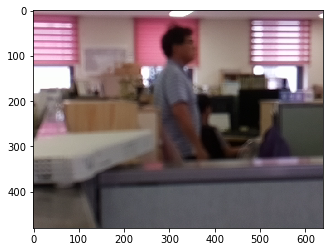

In [124]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread("./RP_data_3/critical/NeuroSafe-20170712_120329_321515.png")
plt.imshow(image)
plt.show()

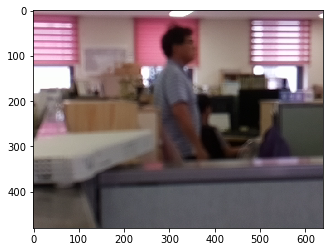

480 640 3

image_data's SHAPE:  (480, 640, 3)
image_data's type:  <class 'numpy.ndarray'>

image_data's SHAPE:  (921600,)
image_data's type:  <class 'numpy.ndarray'>

[[182 145 156 ...,  89  87  95]]
<class 'numpy.ndarray'>
(1, 921600)


In [128]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.misc import imread
import numpy as np
import os
import tensorflow as tf

DATASET_PATH = "./RP_data_3/critical"
def return_filename():
    image_filenames = glob.glob("./RP_data_3/critical/*.png")
    filename = []
    for image_filename in image_filenames:
        filename.append(image_filename.split("/")[3])
#     print(filename)
    return filename

# image_data = imread("./RP_data_3/critical/NeuroSafe-20170712_120329_321515.png")
image = mpimg.imread(DATASET_PATH + '/' + filename[0])
plt.imshow(image)
plt.show()

(width, height, channel) = (image_data.shape)
print(width, height, channel)
print()
print("image_data's SHAPE: ", image_data.shape)
print("image_data's type: ", (type(image_data)))
print()
image_data = image_data.reshape(640*480*3)
print("image_data's SHAPE: ", image_data.shape)
print("image_data's type: ",(type(image_data)))
print()

train_data = []
train_data.append(image_data)
train_data = np.asarray(train_data)

print(train_data)
print(type(train_data))
print(train_data.shape)




In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.misc import imread
import numpy as np
import os
import tensorflow as tf

DATASET_PATH = "./RP_data_3/critical"
def return_filename():
    image_filenames = glob.glob("./RP_data_3/critical/*.png")
    filename = []
    for image_filename in image_filenames:
        filename.append(image_filename.split("/")[3])
#     print(filename)
    return filename

# image_data = imread("./RP_data_3/critical/NeuroSafe-20170712_120329_321515.png")
image = mpimg.imread(DATASET_PATH + '/' + filename[0])
plt.imshow(image)
plt.show()

(width, height, channel) = (image_data.shape)
print(width, height, channel)
print()
print("image_data's SHAPE: ", image_data.shape)
print("image_data's type: ", (type(image_data)))
print()
image_data = image_data.reshape(640*480*3)
print("image_data's SHAPE: ", image_data.shape)
print("image_data's type: ",(type(image_data)))
print()

train_data = []
train_data.append(image_data)
train_data = np.asarray(train_data)

print(train_data)
print(type(train_data))
print(train_data.shape)